In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import seaborn as sns
sns.set(font_scale=2, style='ticks')
# from activity_swim_bout import *
from utils import cont_mode
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from utils import *
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import sem

In [2]:
dir_folder = '/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/'
vol_file = Path('../Analysis/depreciated/analysis_sections_gain.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
t_pre = 100 # time window pre-swim
t_post = 350 # time window post-swim

## Gain adapation

In [3]:
def gain_trace(row):
    folder = row['folder']
    fish = row['fish']
    dat_dir = dir_folder+f'{folder}/{fish}/Data/'
    swim_dir = dir_folder+f'{folder}/{fish}/swim/'
    dff = np.load(dat_dir+'Voltr_spikes.npz')['voltrs']
    dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
    spk = np.load(dat_dir+'Voltr_spikes.npz')['spk']
    num_cell = spk.shape[0]
    spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
    frame_stimParams = np.load(swim_dir+'frame_stimParams.npy')
    frame_swim_tcourse = np.load(swim_dir+'frame_swim_tcourse.npy')
    
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
    swim_starts = _['swim_starts']
    swim_ends = _['swim_ends']
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    visu = _['visu']
    task_period = _['task_period']
    swim_task_index = _['swim_task_index']
    
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_pop_dat.npz')
    sub_swim = _['sub_swim']
    spk_swim = _['spk_swim']
    
    sub_list_ = spk_swim[:, :, t_pre:-60].mean(axis=-1).T
    valid_trial = np.isnan(sub_list_.sum(axis=-1))
    task_period[valid_trial] = np.inf
    lda = LDA()
    lda.fit(sub_list_[task_period<3, :], task_period[task_period<3])
    lad_score = lda.score(sub_list_[task_period<3, :], task_period[task_period<3])
    
    if lad_score<0.7:
        return None, None
    
    coef_ = lda.coef_
    coef_ = coef_/np.linalg.norm(coef_)
    
    k_ = boxcarKernel(1201)
    spk_smooth = spk.copy()
    for ncell in range(spk_smooth.shape[0]):
        spk_smooth[ncell] = smooth(spk[ncell], k_)*300
    pop_act = spk_smooth.T.dot(coef_.T)
    pop_act = pop_act.ravel()
    
    num_burst = np.zeros(r_swim.shape[0])
    int_burst = np.zeros(r_swim.shape[0])
    max_burst = np.zeros(r_swim.shape[0])
    ave_burst = np.zeros(r_swim.shape[0])
    fir_burst = np.zeros(r_swim.shape[0])

    for n_burst in range(r_swim.shape[0]):
        rswim = r_swim[n_burst, 50:200]
        lswim = l_swim[n_burst, 50:200]
        swim_ = np.sqrt(rswim**2+lswim**2)
        peaks_ = find_peaks(swim_, prominence=0.5)[0] 
        if len(peaks_) >1:
            num_burst[n_burst] = len(peaks_)/2
            int_burst[n_burst] = np.nanmean(np.diff(peaks_))
            max_burst[n_burst] = swim_.max()
            ave_burst[n_burst] = swim_[peaks_].mean()
            fir_burst[n_burst] = peaks_[0]

    burst_list = [num_burst, int_burst, max_burst, ave_burst, fir_burst]
    burst_list = np.asarray(burst_list)
    
    n_task = task_period.max().astype('int')
    swim_task_index_ = (swim_task_index-1)%n_task+1
    swim_bout_index_task = np.zeros(len(swim_task_index_)).astype('int')
    swim_bout_index_task[0] = 1
    for n_bout in range(len(swim_task_index_)-1):
        if swim_task_index_[n_bout] == swim_task_index_[n_bout-1]:
            swim_bout_index_task[n_bout] = swim_bout_index_task[n_bout-1]+1
        else:
            swim_bout_index_task[n_bout] = 1

    tmin = -1
    tmax = 19
        
    low_on = np.where((frame_stimParams[2][:-1]==frame_stimParams[2].max()) & (frame_stimParams[2][1:]==1))[0]
    lda_low = np.zeros((len(low_on), (tmax-tmin)*300))
    lda_low[:] = np.nan
    for n in range(len(low_on)-1):
        next_list = np.where(frame_stimParams[2][low_on[n]+1:]!=1)[0]
        if len(next_list)>0:
            tmax_ = min([next_list[0], tmax*300])
            lda_low[n, :tmax_-tmin*300] = pop_act[low_on[n]+tmin*300:low_on[n]+tmax_]
#     ave_ = np.nanmean(lda_low, axis=0)
#     ave_low = ave_.copy()
#     sem_ = np.nanstd(lda_low, axis=0)/np.sqrt(len(low_on))
#     plt.plot(np.arange(tmin, tmax, 1/300), ave_, '-k', lw=2, label='low gain')
#     plt.plot(np.arange(tmin, tmax, 1/300), ave_+sem_, '--k', lw=0.5)
#     plt.plot(np.arange(tmin, tmax, 1/300), ave_-sem_, '--k', lw=0.5)
    
    high_on = np.where((frame_stimParams[2][:-1]==1) & (frame_stimParams[2][1:]==2))[0]
    lda_high = np.zeros((len(high_on), (tmax-tmin)*300))
    lda_high[:] = np.nan
    for n in range(len(high_on)):
        next_list = np.where(frame_stimParams[2][high_on[n]+1:]!=2)[0]
        if len(next_list)>0:
            tmax_ = min([next_list[0], tmax*300])
            lda_high[n, :tmax_-tmin*300] = pop_act[high_on[n]+tmin*300:high_on[n]+tmax_]
            # lda_high[n, :] = pop_act[high_on[n]+tmin*300:high_on[n]+tmax*300]
#     ave_ = np.nanmean(lda_high, axis=0)
#     ave_high = ave_.copy()
#     sem_ = np.nanstd(lda_high, axis=0)/np.sqrt(len(high_on))
#     plt.plot(np.arange(tmin, tmax, 1/300), ave_, '-r', lw=2, label='high gain')
#     plt.plot(np.arange(tmin, tmax, 1/300), ave_+sem_, '--r', lw=0.5)
#     plt.plot(np.arange(tmin, tmax, 1/300), ave_-sem_, '--r', lw=0.5)
#     plt.xlim([-0.25, tmax-0.5])    
#     plt.legend()
#     plt.xlabel('Time from epoch onset')
#     plt.ylabel('Neural act., coding direction')    
#     plt.show()
    return np.nanmean(lda_low, axis=0), np.nanmean(lda_high, axis=0)

In [4]:
low_list = []
high_list = []
for _, row in dat_xls_file.iterrows():
    ave_low, ave_high = gain_trace(row)
    if ave_low is None:
        continue
    low_list.append(ave_low)
    high_list.append(ave_high)

In [5]:
lda_low = np.array(low_list)
lda_high = np.array(high_list)
valid = (lda_high - lda_low)[:, :-200].mean(axis=-1)>0.2

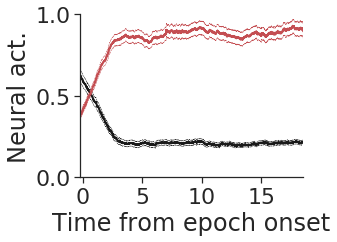

In [11]:
# lda_low = lda_low/lda_high.max(axis=-1, keepdims=True)
# lda_high = lda_high/lda_high.max(axis=-1, keepdims=True)
plt.figure(figsize=(4, 3))
tmin=-1
tmax=19

# ave_ = np.percentile(lda_low, 90, axis=0)
ave_ = np.mean(lda_low[valid], axis=0)
sem_ = sem(lda_low[valid], axis=0)/3
# plt.plot(np.arange(tmin, tmax, 1/300), lda_low.T, '-k', lw=0.5, label='low gain')
plt.plot(np.arange(tmin, tmax, 1/300), ave_, '-k', lw=2, label='low gain')
plt.plot(np.arange(tmin, tmax, 1/300), ave_+sem_, '--k', lw=0.5)
plt.plot(np.arange(tmin, tmax, 1/300), ave_-sem_, '--k', lw=0.5)

# ave_ = np.percentile(lda_high, 90, axis=0)
ave_ = np.mean(lda_high[valid], axis=0)
sem_ = sem(lda_high[valid], axis=0)/3
# plt.plot(np.arange(tmin, tmax, 1/300), lda_high.T, '-r', lw=0.5, label='high gain')
plt.plot(np.arange(tmin, tmax, 1/300), ave_, '-r', lw=2, label='high gain')
plt.plot(np.arange(tmin, tmax, 1/300), ave_+sem_, '--r', lw=0.5)
plt.plot(np.arange(tmin, tmax, 1/300), ave_-sem_, '--r', lw=0.5)
plt.xlim([-0.25, tmax-0.5])    
plt.ylim([0, 1])
plt.xlabel('Time from epoch onset')
plt.xticks(np.arange(0, 20, 5))
plt.ylabel('Neural act.')
sns.despine()
plt.savefig('../Plots/population/gain_adaptation.svg')

## Memory task

In [12]:
def memory_trace(row):
    folder = row['folder']
    fish = row['fish']
    dat_dir = dir_folder+f'{folder}/{fish}/Data/'
    swim_dir = dir_folder+f'{folder}/{fish}/swim/'
    dff = np.load(dat_dir+'Voltr_spikes.npz')['voltrs']
    dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
    spk = np.load(dat_dir+'Voltr_spikes.npz')['spk']
    num_cell = spk.shape[0]
    spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
    frame_stimParams = np.load(swim_dir+'frame_stimParams.npy')
    frame_swim_tcourse = np.load(swim_dir+'frame_swim_tcourse.npy')
    
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
    swim_starts = _['swim_starts']
    swim_ends = _['swim_ends']
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    visu = _['visu']
    task_period = _['task_period']
    swim_task_index = _['swim_task_index']
    
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_pop_dat.npz')
    sub_swim = _['sub_swim']
    spk_swim = _['spk_swim']
    
    sub_list_ = spk_swim[:, :, t_pre:-60].mean(axis=-1).T
    valid_trial = np.isnan(sub_list_.sum(axis=-1))
    task_period[valid_trial] = np.inf
    lda = LDA()
    lda.fit(sub_list_[task_period<3, :], task_period[task_period<3])
    lad_score = lda.score(sub_list_[task_period<3, :], task_period[task_period<3])
    
    if lad_score<0.7:
        return None, None
    
    coef_ = lda.coef_
    coef_ = coef_/np.linalg.norm(coef_)
    
    k_ = boxcarKernel(1201)
    spk_smooth = spk.copy()
    for ncell in range(spk_smooth.shape[0]):
        spk_smooth[ncell] = smooth(spk[ncell], k_)*300
    pop_act = spk_smooth.T.dot(coef_.T)
    pop_act = pop_act.ravel()
    
    num_burst = np.zeros(r_swim.shape[0])
    int_burst = np.zeros(r_swim.shape[0])
    max_burst = np.zeros(r_swim.shape[0])
    ave_burst = np.zeros(r_swim.shape[0])
    fir_burst = np.zeros(r_swim.shape[0])

    for n_burst in range(r_swim.shape[0]):
        rswim = r_swim[n_burst, 50:200]
        lswim = l_swim[n_burst, 50:200]
        swim_ = np.sqrt(rswim**2+lswim**2)
        peaks_ = find_peaks(swim_, prominence=0.5)[0] 
        if len(peaks_) >1:
            num_burst[n_burst] = len(peaks_)/2
            int_burst[n_burst] = np.nanmean(np.diff(peaks_))
            max_burst[n_burst] = swim_.max()
            ave_burst[n_burst] = swim_[peaks_].mean()
            fir_burst[n_burst] = peaks_[0]

    burst_list = [num_burst, int_burst, max_burst, ave_burst, fir_burst]
    burst_list = np.asarray(burst_list)
    
    n_task = task_period.max().astype('int')
    swim_task_index_ = (swim_task_index-1)%n_task+1
    swim_bout_index_task = np.zeros(len(swim_task_index_)).astype('int')
    swim_bout_index_task[0] = 1
    for n_bout in range(len(swim_task_index_)-1):
        if swim_task_index_[n_bout] == swim_task_index_[n_bout-1]:
            swim_bout_index_task[n_bout] = swim_bout_index_task[n_bout-1]+1
        else:
            swim_bout_index_task[n_bout] = 1
            
    tmin = -1
    tmax = 11
    memory_on = np.where((frame_stimParams[2][:-1]==2) & (frame_stimParams[2][1:]==3))[0]#np.where((frame_stimParams[2][:-1]==2) & (np.diff(frame_stimParams[2])==1))[0]
    memory_task = frame_stimParams[3][memory_on]
    lda_mem = np.zeros((len(memory_on), (tmax-tmin)*300))
    for n in range(len(memory_on)):
        lda_mem[n, :] = pop_act[memory_on[n]+tmin*300:memory_on[n]+tmax*300]
    
    
    swim_on_ind = (swim_bout_index_task== 1) & (task_period==4)
    task_info = frame_stimParams[3][swim_starts][swim_on_ind].astype(int)
    valid_memory_trial = np.empty((len(memory_on)//3, 3))
    valid_memory_trial[:] = np.nan
    mm = int(0)
    for m, n__ in enumerate(task_info):
        valid_memory_trial[mm, n__-1] = burst_list[3][swim_on_ind][m]
        if m<len(task_info)-1 and n__>=task_info[m+1]:
            mm += 1
            
    valid_memory_trial = valid_memory_trial[:,0]>valid_memory_trial[:,2]
    if valid_memory_trial.sum() ==0:
        return None, None
    
#     plt.plot(np.arange(tmin, tmax, 1/300), lda_mem[memory_task==1][valid_memory_trial].mean(axis=0), '-b')
#     plt.plot(np.arange(tmin, tmax, 1/300), lda_mem[memory_task==3][valid_memory_trial].mean(axis=0), '-m')
#     plt.xlim([-0.25, tmax-0.5])    
#     plt.xlabel('Time from epoch onset')
#     plt.ylabel('Neural act., coding direction')    
#     plt.show()
    return lda_mem[memory_task==1][valid_memory_trial].mean(axis=0), lda_mem[memory_task==3][valid_memory_trial].mean(axis=0)

In [13]:
low_list_m = []
high_list_m = []
for _, row in dat_xls_file.iterrows():
    if 'memory' in row['task']:
        ave_low, ave_high = memory_trace(row)
        if ave_low is None:
            continue
        low_list_m.append(ave_low)
        high_list_m.append(ave_high)

In [14]:
lda_low = np.array(low_list)
lda_high = np.array(high_list)
valid = (lda_high - lda_low)[:, :-200].mean(axis=-1)>0.2
valid = valid[:len(low_list_m)]

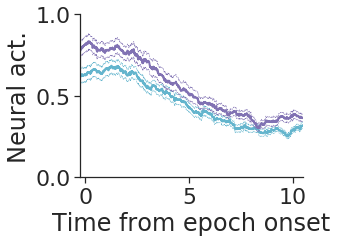

In [15]:
lda_low = np.array(low_list_m)[valid]
lda_high = np.array(high_list_m)[valid]

plt.figure(figsize=(4, 3))
# lda_low = lda_low/lda_high.max(axis=-1, keepdims=True)
# lda_high = lda_high/lda_high.max(axis=-1, keepdims=True)

tmin=-1
tmax=11

# ave_ = np.percentile(lda_low, 90, axis=0)
ave_ = np.mean(lda_low, axis=0)
sem_ = sem(lda_low, axis=0)/3
# plt.plot(np.arange(tmin, tmax, 1/300), lda_low.T, '-k', lw=0.5, label='low gain')
plt.plot(np.arange(tmin, tmax, 1/300), ave_, '-c', lw=2, label='low gain')
plt.plot(np.arange(tmin, tmax, 1/300), ave_+sem_, '--c', lw=0.5)
plt.plot(np.arange(tmin, tmax, 1/300), ave_-sem_, '--c', lw=0.5)

# ave_ = np.percentile(lda_high, 90, axis=0)
ave_ = np.mean(lda_high, axis=0)
sem_ = sem(lda_high, axis=0)/3
# plt.plot(np.arange(tmin, tmax, 1/300), lda_high.T, '-r', lw=0.5, label='high gain')
plt.plot(np.arange(tmin, tmax, 1/300), ave_, '-m', lw=2, label='high gain')
plt.plot(np.arange(tmin, tmax, 1/300), ave_+sem_, '--m', lw=0.5)
plt.plot(np.arange(tmin, tmax, 1/300), ave_-sem_, '--m', lw=0.5)
plt.xlim([-0.25, tmax-0.5])    

plt.ylim([0, 1])
plt.xlabel('Time from epoch onset')
plt.xticks(np.arange(0, 15, 5))
plt.ylabel('Neural act.')
sns.despine()
plt.savefig('../Plots/population/memory_delay.svg')